In [16]:
import os
import sys
import numpy as np
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as dset
import torchvision.utils as vutils
import matplotlib.pyplot as plt

import time 

# Generative Adversarial Networks


Las GANs, concebidas por Ian Goodfellow y sus colegas en 2014, han revolucionado la forma en que las máquinas pueden aprender a generar contenido completamente nuevo. Desde la creación de imágenes hiperrealistas hasta la producción de música y texto, las GANs representan la culminación de décadas de avances en el campo del aprendizaje profundo.

En este notebook, desglosaremos los conceptos fundamentales detrás de las GANs, exploraremos su arquitectura única de generador y discriminador, y analizaremos cómo estas redes neuronales adversarias pueden ser entrenadas para crear datos que son indistinguibles de los datos reales.

Prepárense para sumergirse en líneas de código que darán vida a la creatividad de las máquinas. Desde la implementación básica hasta aplicaciones más avanzadas, este notebook es su guía práctica para desbloquear el potencial ilimitado de las GANs.

In [17]:
# Definimos algunos hiperparametros
CUDA = True
DATA_PATH = './data'
BATCH_SIZE = 128
IMAGE_CHANNEL = 1
Z_DIM = 100
G_HIDDEN = 64
X_DIM = 64
D_HIDDEN = 64
EPOCH_NUM = 30
REAL_LABEL = 1
FAKE_LABEL = 0
lr = 2e-4
seed = 42

Incluimos aceleración por GPU: Éste es uno de nuestros primeros retos a nivel computacional.

In [18]:

CUDA = CUDA and torch.cuda.is_available()
print("PyTorch version: {}".format(torch.__version__))
if CUDA:
    print("CUDA version: {}\n".format(torch.version.cuda))

if CUDA:
    torch.cuda.manual_seed(seed)
device = torch.device("cuda:0" if CUDA else "cpu")
cudnn.benchmark = True

PyTorch version: 2.1.0
CUDA version: 11.8



Cargamos los datos, hemos seleccionado el conjunto de datos MNIST, una elección popular y atemporal en el mundo del aprendizaje profundo.

MNIST, que significa Modified National Institute of Standards and Technology, es una colección de imágenes de dígitos escritos a mano que abarcan desde el 0 hasta el 9. Este conjunto de datos ha servido como un punto de partida para muchos entusiastas y profesionales que exploran el campo de las redes neuronales.

Estos 70,000 dígitos en blanco y negro, divididos en un conjunto de entrenamiento y otro de prueba, son mucho más que simples imágenes. Representan un lienzo en blanco que nuestra red neuronal adversaria utilizará para aprender y luego crear obras de arte digitales por sí misma.

In [19]:
# Data preprocessing
dataset = dset.MNIST(root=DATA_PATH, download=True,
                     transform=transforms.Compose([
                     transforms.Resize(X_DIM),
                     transforms.ToTensor(),
                     transforms.Normalize((0.5,), (0.5,))
                     ]))

# Dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE,
                                         shuffle=True, num_workers=2)

Visualizamos las imagenes de entrenamiento.

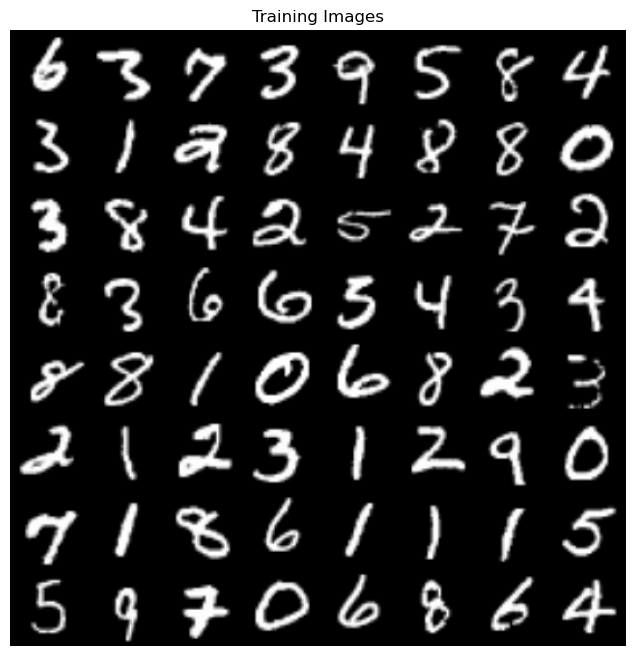

In [20]:
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))


Inicializamos los pesos de la red neuronal

In [21]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [23]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 3060'

Creamos el generador.

In [24]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input layer
            nn.ConvTranspose2d(Z_DIM, G_HIDDEN * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(G_HIDDEN * 8),
            nn.ReLU(True),
            # 1st hidden layer
            nn.ConvTranspose2d(G_HIDDEN * 8, G_HIDDEN * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(G_HIDDEN * 4),
            nn.ReLU(True),
            # 2nd hidden layer
            nn.ConvTranspose2d(G_HIDDEN * 4, G_HIDDEN * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(G_HIDDEN * 2),
            nn.ReLU(True),
            # 3rd hidden layer
            nn.ConvTranspose2d(G_HIDDEN * 2, G_HIDDEN, 4, 2, 1, bias=False),
            nn.BatchNorm2d(G_HIDDEN),
            nn.ReLU(True),
            # output layer
            nn.ConvTranspose2d(G_HIDDEN, IMAGE_CHANNEL, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

In [25]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # 1st layer
            nn.Conv2d(IMAGE_CHANNEL, D_HIDDEN, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # 2nd layer
            nn.Conv2d(D_HIDDEN, D_HIDDEN * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(D_HIDDEN * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # 3rd layer
            nn.Conv2d(D_HIDDEN * 2, D_HIDDEN * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(D_HIDDEN * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # 4th layer
            nn.Conv2d(D_HIDDEN * 4, D_HIDDEN * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(D_HIDDEN * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # output layer
            nn.Conv2d(D_HIDDEN * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input).view(-1, 1).squeeze(1)

In [26]:
# Create the generator
netG = Generator().to(device)
netG.apply(weights_init)
print(netG)

# Create the discriminator
netD = Discriminator().to(device)
netD.apply(weights_init)
print(netD)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [ ]:
from torchviz import make_dot

make_dot(yhat, params=dict(list(model.named_parameters()))).render("rnn_torchviz", format="png")

In [27]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that I will use to visualize the progression of the generator
viz_noise = torch.randn(BATCH_SIZE, Z_DIM, 1, 1, device=device)

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(0.5, 0.999))

In [28]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
for epoch in range(EPOCH_NUM):
    start = time.time()
    for i, data in enumerate(dataloader, 0):

        # (1) Update the discriminator with real data
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), REAL_LABEL, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        # (2) Update the discriminator with fake data
        # Generate batch of latent vectors
        noise = torch.randn(b_size, Z_DIM, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(FAKE_LABEL)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        # (3) Update the generator with fake data
        netG.zero_grad()
        label.fill_(REAL_LABEL)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, EPOCH_NUM, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == EPOCH_NUM-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(viz_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

Starting Training Loop...
[0/30][0/469]	Loss_D: 1.3966	Loss_G: 5.7640	D(x): 0.6610	D(G(z)): 0.5464 / 0.0050
[0/30][50/469]	Loss_D: 0.2723	Loss_G: 14.3389	D(x): 0.9966	D(G(z)): 0.2180 / 0.0000
[0/30][100/469]	Loss_D: 0.1306	Loss_G: 5.3794	D(x): 0.9417	D(G(z)): 0.0586 / 0.0059
[0/30][150/469]	Loss_D: 0.2102	Loss_G: 4.2801	D(x): 0.8888	D(G(z)): 0.0645 / 0.0228
[0/30][200/469]	Loss_D: 0.3403	Loss_G: 3.3387	D(x): 0.9894	D(G(z)): 0.2415 / 0.0603
[0/30][250/469]	Loss_D: 0.2249	Loss_G: 3.8997	D(x): 0.9187	D(G(z)): 0.1114 / 0.0308
[0/30][300/469]	Loss_D: 0.1121	Loss_G: 3.3266	D(x): 0.9267	D(G(z)): 0.0289 / 0.0508
[0/30][350/469]	Loss_D: 0.1734	Loss_G: 4.0421	D(x): 0.9674	D(G(z)): 0.1192 / 0.0311
[0/30][400/469]	Loss_D: 0.2730	Loss_G: 3.4442	D(x): 0.8774	D(G(z)): 0.1124 / 0.0553
[0/30][450/469]	Loss_D: 0.1907	Loss_G: 3.0077	D(x): 0.9072	D(G(z)): 0.0804 / 0.0712
Time for epoch 1 is 26.022983074188232 sec
[1/30][0/469]	Loss_D: 0.2817	Loss_G: 3.5885	D(x): 0.8821	D(G(z)): 0.1291 / 0.0428
[1/30][50/4

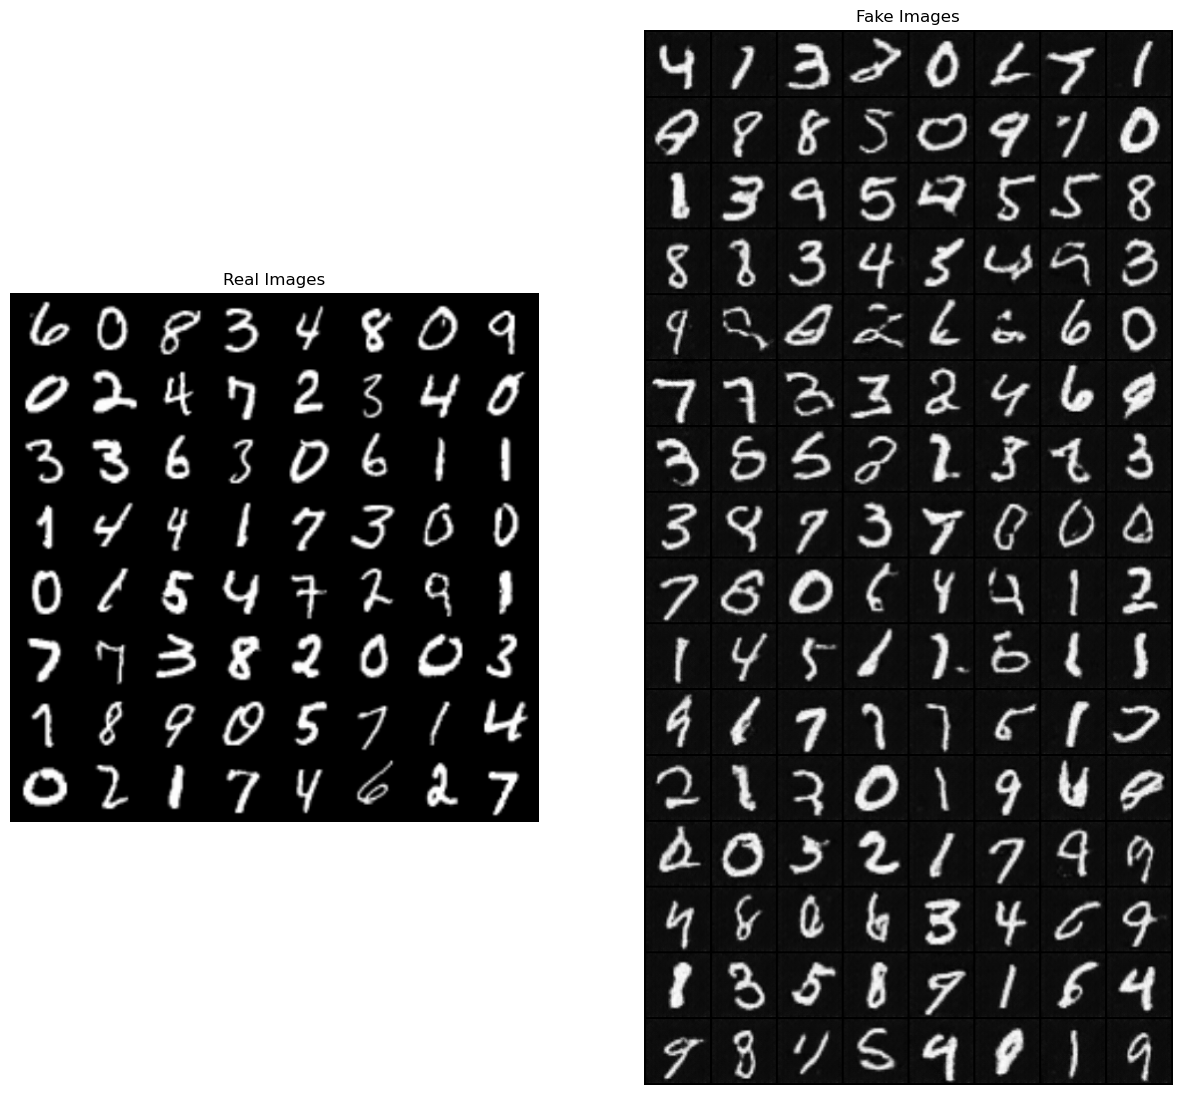

In [29]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()